# Convolutional autoencoder on STFT data

Taken from https://github.com/pkmital/tensorflow_tutorials/blob/master/python/08_denoising_autoencoder.py


In [52]:
from __future__ import division, print_function, absolute_import
%pylab inline
import wget
import librosa
import tensorflow as tf
import numpy as np
import os
from utils import *


Populating the interactive namespace from numpy and matplotlib


In [9]:
path = "../wavs/"
fname = 'Stockhausen_Kontakte.wav'
fname = 'mipais.wav'

filename = path+fname

fs,x = wav2audio_segment(filename)
S = audio2spectral(x,orig_fs=fs,resample_fs=22050,magnitude=False,normalize=False,representation='STFT',nfft_size= 2**10,nfft_hop=2**8,
         frame_size=64, n_bins = 64,normalization_axis=None)

In [3]:
def normalize(x,axis=0):
    return (x-x.min())/(x.max()-x.min())

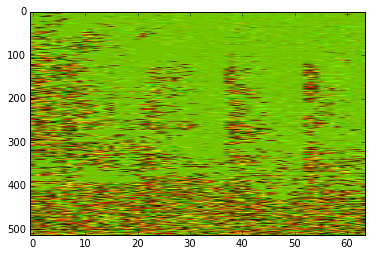

In [80]:
#imshow(S[10].imag,aspect='auto',cmap=cm.seismic)

c = 28
C = np.array([ normalize(S[c].real,0)*255,normalize(S[c].imag,0)*255,zeros(S[c].shape)])

imshow(np.rollaxis(C,0,3),aspect='auto')



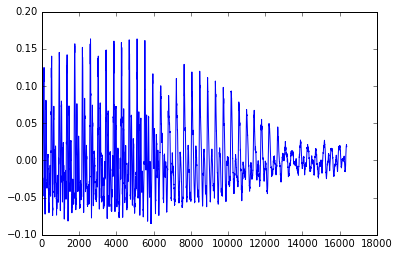

In [40]:
import IPython
sr=fs
spec_duration=64*256
start_time=17*fs
plot(x[start_time:start_time+spec_duration])
sound=x[start_time:start_time+spec_duration]
start_time2=11*fs
sound2=x[start_time2:start_time2+spec_duration]
start_time3=19*fs
sound3=x[start_time3:start_time3+spec_duration]
IPython.display.Audio(data=r_[sound,sound,sound,sound2,sound3], rate=sr)

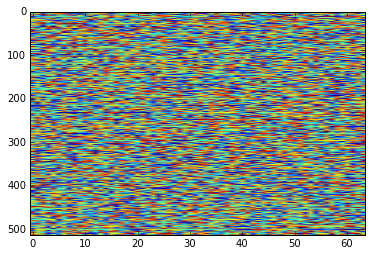

In [73]:
imshow(angle(S[200]),aspect='auto')

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


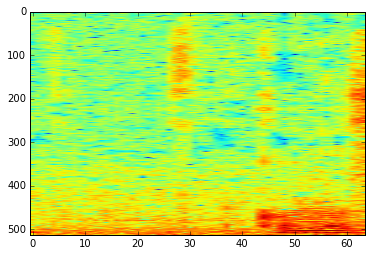

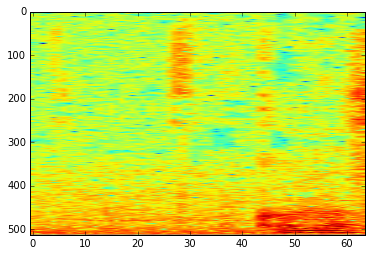

In [79]:
imshow(log10(abs(real(S[200]))),aspect='auto')
figure()
imshow(log10(abs(imag(S[200]))),aspect='auto')

In [70]:
start_time=17*fs
sound_before=x[start_time:start_time+spec_duration]
D=librosa.stft(sound_before, n_fft=512, win_length=512)
sound_after=librosa.istft(D, win_length=512);

IPython.display.Audio(data=sound_before, rate=fs)
#IPython.display.Audio(data=sound_after, rate=fs)

In [68]:
IPython.display.Audio(data=sound_after, rate=fs)

In [71]:
IPython.display.Audio(data=r_[sound_before, sound_after, sound_before,sound_before, sound_after], rate=fs)

Dimensions: data length, freq bins, time bins
372 513 64


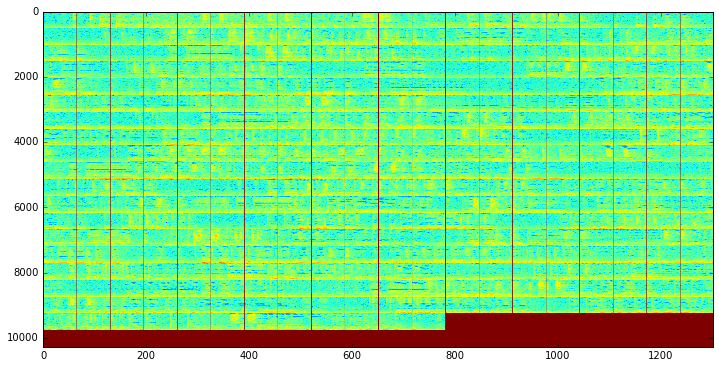

In [41]:
print("Dimensions: data length, freq bins, time bins")
total_length, freq_bins,time_bins = S.shape
print(total_length, freq_bins,time_bins)

# imshow(S[21],aspect='auto',origin='bottom');
figure(figsize=(12,6))
imshow(montage(log10(abs(S))),aspect='auto');


In [155]:
train_length = 120
test_length = total_length - train_length
ixs = np.arange(total_length)
np.random.shuffle(ixs)

C = np.array([normalize(S.real,0),normalize(S.imag,0)])
C = np.rollaxis(C,0,4)

data = Data( C[ixs[:train_length],:,:,:].reshape((train_length,freq_bins*time_bins*2)) )
test = Data( C[ixs[train_length:train_length+test_length],:,:,:].reshape((test_length,freq_bins*time_bins*2)) )

In [148]:
C.shape, G.shape
data.data.shape

(120, 32832, 2)

In [167]:
mean_img = data.data.mean(0)

batch_size = 60
n_epochs = 300
learning_rate = 0.001
n_filters=[16,16,16]
n_features =  int(data.data.shape[1])
input_shape = [None, n_features]
filter_sizes = [4,4,4]
stri = [1, 2, 2, 1]

In [163]:
input_shape

[None, 65664]

In [168]:
# %%
tf.reset_default_graph()
# input to the network
X = tf.placeholder( tf.float32, input_shape, name='x')

X_tensor = tf.reshape(X, [-1, freq_bins, time_bins, 2])

current_input = X_tensor

# notice instead of having 784 as our input features, we're going to have
# just 1, corresponding to the number of channels in the image.
# We're going to use convolution to find 16 filters, or 16 channels of information in each spatial location we perform convolution at.
n_input = 2

# We're going to keep every matrix we create so let's create a list to hold them all
Ws = []
shapes = []
l = []

# We'll create a for loop to create each layer:
for layer_i, n_output in enumerate(n_filters):
    # just like in the last session,
    # we'll use a variable scope to help encapsulate our variables
    # This will simply prefix all the variables made in this scope
    # with the name we give it.
    with tf.variable_scope("encoder/layer/{}".format(layer_i)):
        # we'll keep track of the shapes of each layer
        # As we'll need these for the decoder
        shapes.append(current_input.get_shape().as_list())
        l.append(current_input)
        # Create a weight matrix which will increasingly reduce
        # down the amount of information in the input by performing
        # a matrix multiplication
        W = tf.get_variable(
            name='W',
            shape=[
                filter_sizes[layer_i],
                filter_sizes[layer_i],
                n_input,
                n_output],
            initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))

        # Now we'll convolve our input by our newly created W matrix
        h = tf.nn.conv2d(current_input, W,
            strides=stri, padding='SAME')

        # And then use a relu activation function on its output
        current_input = tf.nn.relu(h)
        

        # Finally we'll store the weight matrix so we can build the decoder.
        Ws.append(W)

        # We'll also replace n_input with the current n_output, so that on the
        # next iteration, our new number inputs will be correct.
        n_input = n_output

z = current_input
# %%
# store the latent representation
Ws.reverse()
# and the shapes of each layer
shapes.reverse()
# and the number of filters (which is the same but could have been different)
n_filters.reverse()
# and append the last filter size which is our input image's number of channels
n_filters = n_filters[1:] + [1]

print(n_filters, filter_sizes, shapes)

# %%
# Build the decoder using the same weights
for layer_i, shape in enumerate(shapes):
    # we'll use a variable scope to help encapsulate our variables
    # This will simply prefix all the variables made in this scope
    # with the name we give it.
    with tf.variable_scope("decoder/layer/{}".format(layer_i)):
        l.append(current_input)
        # Create a weight matrix which will increasingly reduce
        # down the amount of information in the input by performing
        # a matrix multiplication
        W = Ws[layer_i]

        # Now we'll convolve by the transpose of our previous convolution tensor
        h = tf.nn.conv2d_transpose(current_input, W,
            tf.pack([tf.shape(X)[0], shape[1], shape[2], shape[3]]),
            strides=stri, padding='SAME')

        # And then use a relu activation function on its output
        current_input = tf.nn.relu(h)
        
l.append(current_input)

# %%
# now have the reconstruction through the network
Y = current_input
Y = tf.reshape(Y, [-1, n_features])
# cost function measures pixel-wise difference
cost = tf.reduce_mean(tf.reduce_mean(tf.squared_difference(X, Y), 1))

ae = {'X': X, 'z': z, 'Y': Y, 'cost': cost}

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)


[16, 16, 1] [4, 4, 4] [[None, 129, 16, 16], [None, 257, 32, 16], [None, 513, 64, 2]]


[16, 16, 1] [4, 4, 4] [[None, 129, 16, 16], [None, 257, 32, 16], [None, 513, 64, 2]]


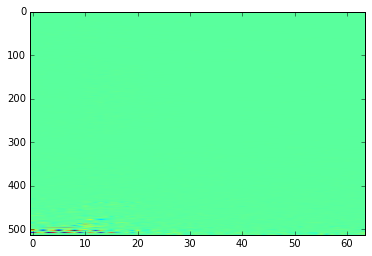

In [169]:
print(n_filters, filter_sizes, shapes)
imshow(data.next_batch(batch_size)[0].reshape((freq_bins,time_bins,2))[:,:,0],aspect='auto')

In [170]:
# %%
# We create a session to use the graph
config = tf.ConfigProto( device_count = {'GPU': 1} )
sess = tf.Session(config=config)
sess.run(tf.initialize_all_variables())

# %%
# Fit all training data

total_batch = int(data.length/batch_size)
for epoch_i in range(n_epochs):
    for batch_i in range(total_batch):
        batch_xs = data.next_batch(batch_size)

        sess.run(optimizer, feed_dict={ae['X']: batch_xs-mean_img })
    
    if epoch_i%5==0:
        print(epoch_i, sess.run(ae['cost'], feed_dict={ae['X']: batch_xs-mean_img}))

0 2.63093e-05
5 2.67766e-05
10 2.96688e-05
15 2.7051e-05
20 2.63368e-05
25 3.10624e-05
30 2.78462e-05
35 3.01672e-05
40 2.68447e-05
45 2.45845e-05
50 2.38953e-05
55 2.86902e-05
60 2.62463e-05
65 2.77332e-05
70 2.34546e-05
75 2.66877e-05
80 2.8653e-05
85 2.91562e-05
90 2.73223e-05
95 2.99827e-05
100 2.49421e-05
105 2.8899e-05
110 2.79113e-05
115 2.69079e-05
120 2.73657e-05
125 3.06015e-05
130 2.90583e-05
135 2.81649e-05
140 2.68104e-05
145 2.80071e-05
150 2.53294e-05
155 2.77694e-05
160 2.87568e-05
165 2.88344e-05
170 2.78921e-05
175 2.73611e-05
180 2.6884e-05
185 2.64284e-05
190 2.5772e-05
195 2.92348e-05
200 2.94885e-05
205 2.77597e-05
210 2.67823e-05
215 2.75918e-05
220 2.48762e-05
225 2.5448e-05
230 2.62861e-05
235 2.90959e-05
240 2.9581e-05
245 3.19363e-05
250 2.50536e-05
255 2.82198e-05
260 2.9097e-05
265 2.77577e-05
270 2.36347e-05
275 2.66088e-05
280 2.81482e-05
285 2.84492e-05
290 2.62792e-05
295 2.58303e-05


In [194]:
compare = [3,21,25]

recon = sess.run(ae['Y'], feed_dict={ ae['X']: data.data[compare]-mean_img})
#recon = recon.T
recon.shape, freq_bins*time_bins*2
recon[1].reshape(freq_bins,time_bins,2).shape

(513, 64, 2)

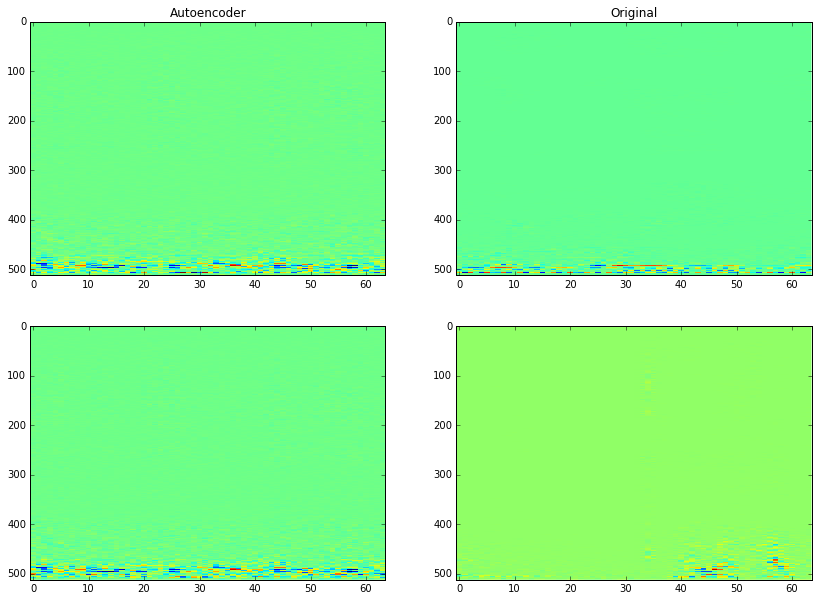

In [193]:
original = data.data[compare]
figure(figsize=(14,10))
for i,c in enumerate(compare):
    
    subplot(len(compare),2,i*2+1)
    imshow(recon[i].reshape(freq_bins,time_bins,2)[:,:,0]+\
           mean_img.reshape(freq_bins,time_bins,2)[:,:,0],aspect='auto',interpolation='none')
    subplot(len(compare),2,i*2+2)
    imshow(original[i].reshape((freq_bins,time_bins,2))[:,:,0],aspect='auto',interpolation='none')

subplot(len(compare),2,1)
title("Autoencoder")
subplot(len(compare),2,2)
title("Original")

# savefig("results_cqt_dim_"+str(dimensions)+"_cost_"+"{:.4f}.png".format(cost_value))

In [173]:
sample = 3

for i,l_ in enumerate(l):
    recon = sess.run(l_, feed_dict={ ae['X']: data.data[sample:sample+1]-mean_img})
    figure()
    
    if i==0 or i== len(l)-1:
        out = recon[0,:,:,0]+mean_img.reshape(freq_bins,time_bins)
    else:
        out = recon[0,:,:,0]
    imshow(out,aspect='auto',interpolation='none')
    
    colorbar()

ValueError: total size of new array must be unchanged

In [174]:
cost = sess.run(ae['cost'], feed_dict={ae['X']: test.data-mean_img})
print(cost)

3.12991e-05


In [175]:
import librosa
import librosa.display
import IPython.display

D = out.astype(np.complex128)
# D = data.data[sample]
# D = D.reshape(freq_bins,time_bins).astype(np.complex128)
D = 10**D
# D  = librosa.phase_vocoder(D, 1.0, hop_length=512)
audio  = librosa.istft(D, hop_length=512)
IPython.display.Audio(data=audio, rate=fs)

NameError: name 'out' is not defined

In [ ]:
imshow(abs(D))

In [ ]:
y, sr   = librosa.load(librosa.util.example_audio_file())
D       = librosa.stft(y, n_fft=2048, hop_length=512)
D = 10**log10(abs(D))
D_fast  = librosa.phase_vocoder(D, 2.0, hop_length=512)
y_fast  = librosa.istft(D_fast, hop_length=512)
IPython.display.Audio(data=y_fast, rate=sr)

In [7]:
D.shape

(1025, 2647)

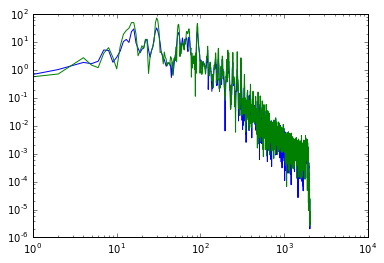

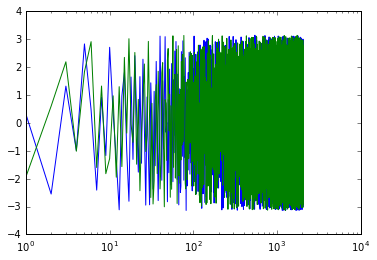

In [45]:
N = 2**12
hop = 2**10
y0, sr   = librosa.load(librosa.util.example_audio_file())
D = librosa.stft(y0, n_fft=N, hop_length=hop)
x = D[:,10:12]
figure()
loglog(abs(x))
figure()
semilogx(angle(x))

In [46]:
t = (ones((2,N))*arange(N)/sr).T
df = sr/N
n = 50
f0 = n*df
y = abs(x[n,:])*cos(angle(x[n,:])+t*f0*2*np.pi)
y = (y.T*hanning(N)).T

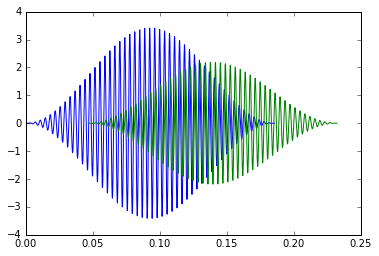

In [47]:
plot(t+[0,hop/sr],y)

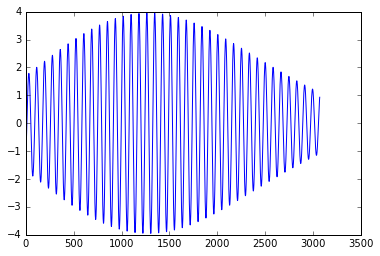

In [48]:
ix = array([arange(hop,N),arange(0,N-hop)]).T
yy = y[ix[:,0],0]+y[ix[:,1],1]
plot(yy)

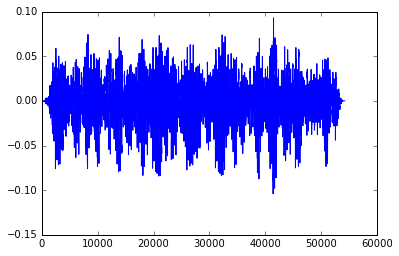

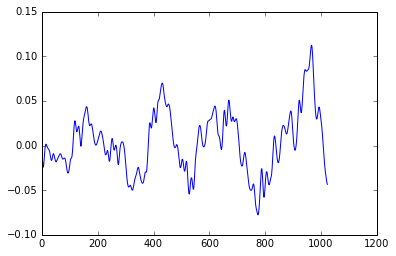

In [54]:
k = 20

size = 50
ks = k+randint(0,5,size)
x = D[:,ks]


yy = zeros(size*hop+3*hop)
t = (ones((size,N))*arange(N)/sr).T
df = sr/N


for n in range(0,int(N/2)):
    f0 = n*df
    y = abs(x[n,:])/N*cos(angle(x[n,:])+t*f0*2*np.pi)
    y = (y.T*hanning(N)).T
    for i in range(size):
        yy[i*hop:i*hop+N] += y[:,i]
    

    
yy0 = y0[k*hop:(k+1)*hop]
plot(yy)

# plot(y0[(k+d)*hop:(k+d)*hop+hop])
figure()
plot(yy0)

In [55]:
IPython.display.Audio(data=yy, rate=sr)

In [40]:
IPython.display.Audio(data=yy0, rate=sr)

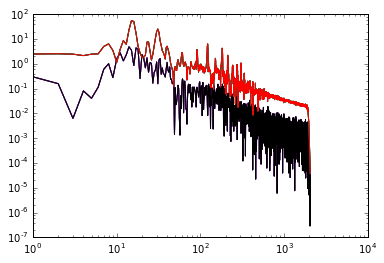

In [37]:
loglog(abs(x))